In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting

# Load the PSD spectra values

In [2]:
with h5py.File( '/home/jovyan/VIIRS_all_99clear_PSD_spectra.h5', 'r') as f:
    
    spectra = f['spectra'][()]
    wavenumbers = f['wavenumbers'][()]
    slopes = f['slopes'][()]
    intercepts = f['intercepts'][()]

In [3]:
spectra.shape

(2291590, 2, 32)

# Load table

In [4]:
viirs_tbl = ulmo_io.load_main_table( 's3://viirs/Tables/VIIRS_all_99clear_std.parquet')
viirs_tbl.head()

Read main table: s3://viirs/Tables/VIIRS_all_99clear_std.parquet


,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,pp_root,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year
0,s3://viirs/data/2012/048/20120217193000-OSPO-L...,720,1248,19.590923,89.338295,4.470527e-17,192,2012-02-17 19:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,5,0,24.843233,24.029999,25.730011,25.119995,24.510010,331.460999,2012
1,s3://viirs/data/2012/047/20120216052000-OSPO-L...,4848,1632,-14.932406,120.176720,1.898872e-04,192,2012-02-16 05:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,6,0,31.347763,29.929993,31.869995,31.579987,31.119995,579.588074,2012
2,s3://viirs/data/2012/050/20120219111000-OSPO-L...,1008,2112,-36.731842,33.399803,8.056641e-03,192,2012-02-19 11:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,9,0,22.753841,20.970001,23.489990,23.089996,22.429993,274.181274,2012
3,s3://viirs/data/2012/201/20120719012000-OSPO-L...,48,1056,38.578500,3.368228,4.882812e-04,192,2012-07-19 01:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,12,0,25.789021,23.619995,26.589996,26.139984,25.420013,266.262878,2012
4,s3://viirs/data/2012/127/20120506022000-OSPO-L...,1488,2016,44.143940,151.003390,1.220703e-03,192,2012-05-06 02:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,14,0,4.603452,3.470001,5.579987,5.059998,4.109985,65.829651,2012


In [5]:
viirs_tbl.tail()

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,pp_root,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year
2291585,s3://viirs/data/2020/302/20201028075000-OSPO-L...,1680,2592,19.539072,70.338720,0.000054,192,2020-10-28 07:50:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1149945,0,29.592403,28.529999,30.309998,29.790009,29.389984,624.228638,2020
2291586,s3://viirs/data/2020/365/20201230081000-OSPO-L...,1104,2784,20.307888,63.778408,0.000814,192,2020-12-30 08:10:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1149946,0,24.783611,23.850006,25.730011,25.019989,24.549988,608.405579,2020
2291587,s3://viirs/data/2020/101/20200410060000-OSPO-L...,5199,2496,48.693790,-48.147537,0.000081,192,2020-04-10 06:00:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1149951,0,2.146864,-1.380005,4.950012,3.649994,-0.170013,-294.058380,2020
2291588,s3://viirs/data/2020/335/20201130032000-OSPO-L...,4464,0,-45.709976,-59.392624,0.000515,192,2020-11-30 03:20:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1149963,0,10.514750,7.959991,14.350006,13.179993,9.119995,-219.793213,2020
2291589,s3://viirs/data/2020/090/20200330160000-OSPO-L...,2928,1632,57.378822,-55.790764,0.003445,192,2020-03-30 16:00:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1149964,0,3.298854,2.570007,4.730011,3.390015,3.209991,774.614990,2020


## zonal slope

In [6]:
slope_obj = pd.Series( data=slopes[:, 1] )

In [7]:
viirs_tbl['zonal_slope'] = slope_obj

## meridional slope

In [8]:
slope_obj = pd.Series( data=slopes[:, 2] )

In [9]:
viirs_tbl['meridional_slope'] = slope_obj

# 2d Histogram

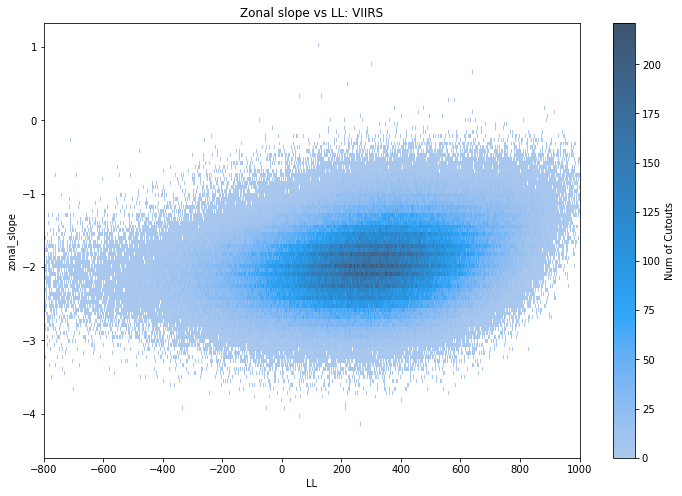

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax = sns.histplot( data = viirs_tbl, x = 'LL', y = 'zonal_slope', bins=100, discrete=(True, False), cbar=True)

ax.set_xlim(-800, 1000)
ax.set_title('Zonal slope vs LL: VIIRS')
ax.collections[0].colorbar.set_label("Num of Cutouts")

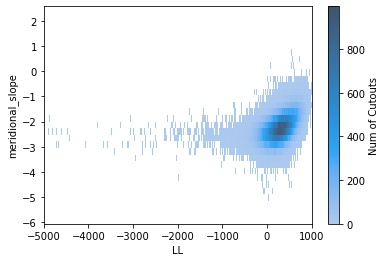

In [11]:
ax = sns.histplot( data = viirs_tbl, x = 'LL', y = 'meridional_slope', bins=30, discrete=(True, False), cbar=True)

ax.set_xlim(-5000, 1000)
ax.collections[0].colorbar.set_label("Num of Cutouts")

# Global Spatial Plots

## Functions

In [9]:
def evals_to_healpix_meds(eval_tbl, nside,  mask=True):
    """
    Generate a healpix map of where the input
    MHW Systems are located on the globe

    Parameters
    ----------
    mhw_sys : pandas.DataFrame
    nside : int  # nside is a number that sets the resolution of map
    mask : bool, optional

    Returns
    -------
    num of events, lats, lons, median values : hp.ma, np.ndarray, np.ndarray, hp.ma

    """
    # Grab lats, lons
    lats = eval_tbl.lat.values
    lons = eval_tbl.lon.values

    # Healpix coords
    theta = (90 - lats) * np.pi / 180.  # convert into radians
    phi = lons * np.pi / 180.
    idx_all = hp.pixelfunc.ang2pix(nside, theta, phi) # returns the healpix pixel numbers that correspond to theta and phi values

    # Intialize the arrays
    npix_hp = hp.nside2npix(nside)  # returns the number of pixels on map, based on nside parameter
    all_events = np.ma.masked_array(np.zeros(npix_hp, dtype='int')) # array of all pixels on map
    med_values = np.ma.masked_array(np.zeros(npix_hp, dtype='float')) # will contain median LL value in that pixel

    # Count events
    for i, idx in enumerate(idx_all):
        all_events[idx] += 1 # pixels concentrated with data pts >= 1 ; those without data remain 0

    zero = all_events == 0 
    float_events = all_events.astype(float)
# ~ operator is called the complement bitwise operator 
# inverts the True/False values
# [~zero] selects pixels where the cutouts are (where events = 1 exist)


    # Calculate median values
    idx_arr = pd.Series(idx_all).sort_values()
    pixels = pd.unique(idx_arr)

    for pixel in pixels: 
    
        # find where which cutouts to put in that pixel
        where = np.where(pixel == idx_arr)
        first = where[0][0]
        last = where[0][-1]
        indices = idx_arr[first:last + 1].index
    
        # evaluate the median LL value for that pixel 
        vals = eval_tbl.iloc[indices.to_numpy()].zonal_slope.to_numpy()
    
        med_values[pixel] = np.median( vals )


    # Mask
    evts = hp.ma(float_events)
    meds = hp.ma(med_values)
    if mask:  # if you want to mask float_events
        evts.mask = zero # current mask set to zero array, where Trues (no events) are masked
        meds.mask = zero 

    # Angles
    hp_lons, hp_lats = hp.pixelfunc.pix2ang(nside, np.arange(npix_hp), lonlat=True)

    # Return
    return evts, hp_lons, hp_lats, meds

In [10]:
def show_med_slope(main_tbl:pd.DataFrame, 
                 nside=64, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='viridis', show=True):
    """Generate a global map of the location of the input
    cutouts
    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True
    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events, hp_lons, hp_lats, hp_values = evals_to_healpix_meds(
        main_tbl, nside, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons, hp_lats, hp_values, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values.mask)
        img = plt.scatter(x=hp_lons[good],
            y=hp_lats[good],
            c=hp_values[good], vmax = -4., vmin = 0,
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        clbl = 'median zonal slope'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    if show:
        plt.show()

    return ax

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


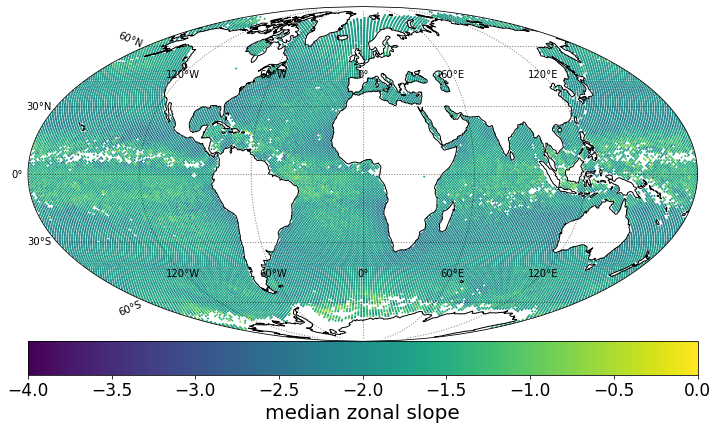

<GeoAxesSubplot:>

In [11]:
show_med_slope(viirs_tbl, lbl=True)